In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import corner
from VegasAfterglow import ObsData, Setups, Fitter, ParamDef, Scale

In [ ]:
######### 1. PREPARE DATA #########
#Create an instance of the ObsData class to store light curve and spectrum data
data = ObsData()

# Define the frequency bands [Hz] and corresponding light curve files
band = [2.4e17, 4.84e14, 1.4e14]
lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]

# Loop through each frequency band and corresponding file(s)
for nu, fname in zip(band, lc_files):
    # Read the light curve data from the CSV file into a pandas DataFrame
    df = pd.read_csv(fname)

    # Add the light curve data to the 'data' object for the given frequency band
    # You can assign weight to each data point for chi^2 evaluation
    # You don't need to worry about the weights' normalization, the code will normalize them automatically.
    data.add_flux_density(nu=nu, t=df["t"], f_nu=df["Fv_obs"], err=df["Fv_err"], weights=np.ones(len(df["t"])))  # All quantities in CGS units

# Define the times [s] for spectra and corresponding files
times = [3000]
spec_files = ["data/ep-spec.csv"]    

# Loop through each time and its corresponding spectrum file
for t, fname in zip(times, spec_files):
    # Read the spectrum data from the CSV file into a pandas DataFrame
    df_spec = pd.read_csv(fname)

    # Add the spectrum data to the 'data' object for the given time
    data.add_spectrum(t=t, nu=df_spec["nu"],
                      f_nu=df_spec["Fv_obs"], err=df_spec["Fv_err"], weights=np.ones(len(df_spec["nu"])))  # All quantities in CGS units

######### 2. CONFIGURE MODEL #########
cfg = Setups()
cfg.lumi_dist = 3.364e28    # Luminosity distance [cm]  
cfg.z         = 1.58        # Redshift
cfg.medium    = "wind"      # Medium type: "wind", "ism" (Interstellar Medium)
cfg.jet       = "powerlaw"  # Jet structure: "powerlaw", "gaussian", "tophat", "two_component", "step_powerlaw" 

######### 3. DEFINE PARAMETERS #########
# Parameter name, lower bound, upper bound, scale type, initial value (optional)

mc_params = [
    ParamDef("E_iso",    1e51,  1e54,  Scale.LOG,    1e53),    # Isotropic energy [erg]
    ParamDef("Gamma0",      5,  1000,  Scale.LOG,      20),    # Lorentz factor at the core
    ParamDef("theta_c",   0.0,   0.5,  Scale.LINEAR,  0.3),    # Core half-opening angle [rad]
    ParamDef("k_e",         2,     2,  Scale.FIXED,     2),    # Energy power law index
    ParamDef("k_g",         2,     2,  Scale.FIXED,     2),    # Lorentz factor power law index
    ParamDef("theta_v",   0.0,   0.0,  Scale.FIXED,   0.0),    # Viewing angle [rad]
    ParamDef("p",           2,     3,  Scale.LINEAR,  2.3),    # Power law index
    ParamDef("eps_e",    1e-2,   0.3,  Scale.LOG,    0.05),    # Electron energy fraction
    ParamDef("eps_B",    1e-4,   0.3,  Scale.LOG,    0.03),    # Magnetic field energy fraction
    ParamDef("xi_e",        1,     1,  Scale.FIXED,     1),    # Electron acceleration efficiency
    ParamDef("A_star",   1e-3,    10,  Scale.LOG,    0.05),    # Wind parameter 
]

######### 4. RUN MCMC SAMPLING #########
# Create an instance of the Fitter class using the prepared data and configuration
fitter = Fitter(data, cfg)

# Run the fitting process using bilby with dynesty sampler
#result = fitter.fit(
#    mc_params,
#    resolution=(0.3, 0.3, 10), # Grid resolution (phi, theta, t) - affects model accuracy
#    sampler="dynesty",         # Use dynesty nested sampler
#    nlive=1000,                # Number of live points
#    walks=100,                 # Number of random walks per live point
#    dlogz=0.5,                 # Stopping criterion
#    top_k=10,                  # Number of best-fit parameters to return
#    npool=2,                   # Number of parallel processes
#    outdir="bilby_output",     # Output directory for results
#    label="afterglow_fit_emcee"    # Run label
#)

# Run the fitting process using bilby with emcee sampler
result = fitter.fit(
#result =   fitter.fit_emcee_vectorized(
    mc_params,
    resolution=(0.3, 0.3, 10),# Grid resolution (phi, theta, t) - affects model accuracy
    sampler="emcee",          # Use emcee MCMC sampler 
    #sampler="bilby_mcmc",
    nsteps=10000,             # Number of steps per walker 
    nburn=3000,               # Burn-in steps to discard
    thin=1,                   # Save every nth sample (1 = save all)
    top_k=10,                 # Number of best-fit parameters to return
    #npool=8,                  # Number of parallel processes
    outdir="bilby_output",    # Output directory for results#
    label="afterglow_fit_emcee"    # Run label#
)

print(f"Total samples: {result.samples.shape[0]}")

# Create a table for top-k parameters
top_k_data = []
for i in range(result.top_k_params.shape[0]):
    row = {'Rank': i+1, 'chi^2': f"{-2*result.top_k_log_probs[i]:.2f}"}
    for name, val in zip(result.labels, result.top_k_params[i]):
        row[name] = f"{val:.4f}"
    top_k_data.append(row)

top_k_df = pd.DataFrame(top_k_data)
print("\nTop-k parameters:")
print(top_k_df.to_string(index=False))

100%|██████████| 10000/10000 [01:24<00:00, 117.68it/s]

Total samples: 224000

Top-k parameters:
 Rank chi^2 log10_E_iso log10_Gamma0 theta_c      p log10_eps_e log10_eps_B log10_A_star
    1 23.46     53.4888       1.6473  0.4156 2.1195     -1.5953     -1.1796      -2.1887
    2 23.49     53.1105       1.6008  0.3046 2.1187     -1.2815     -1.0018      -2.3422
    3 23.51     53.2062       1.5449  0.3713 2.1107     -1.3337     -1.4208      -2.0367
    4 23.51     53.1354       1.5928  0.3865 2.1355     -1.2315     -1.1054      -2.3750
    5 23.52     53.0264       1.5707  0.3340 2.1079     -1.2018     -1.0612      -2.2886
    6 23.54     53.0364       1.5988  0.2781 2.1271     -1.1723     -0.9463      -2.4645
    7 23.55     53.4891       1.6510  0.2812 2.1269     -1.5718     -1.1277      -2.2440
    8 23.58     53.1363       1.4742  0.3979 2.1115     -1.2482     -1.6856      -1.8408
    9 23.59     53.2700       1.6259  0.3599 2.0950     -1.4597     -1.0736      -2.2166
   10 23.59     53.1915       1.6201  0.2778 2.1387     -1.2694     -

In [11]:
# Define time and frequency ranges for predictions
t_out = np.logspace(2, 9, 150)

nu_out = np.logspace(16,20,150)

best_params = result.top_k_params[0]

# Generate model light curves at the specified bands using the best-fit parameters
lc = fitter.flux_density_grid(best_params, t_out, band)

# Generate model spectra at the specified times using the best-fit parameters
spec = fitter.flux_density_grid(best_params, times, nu_out)

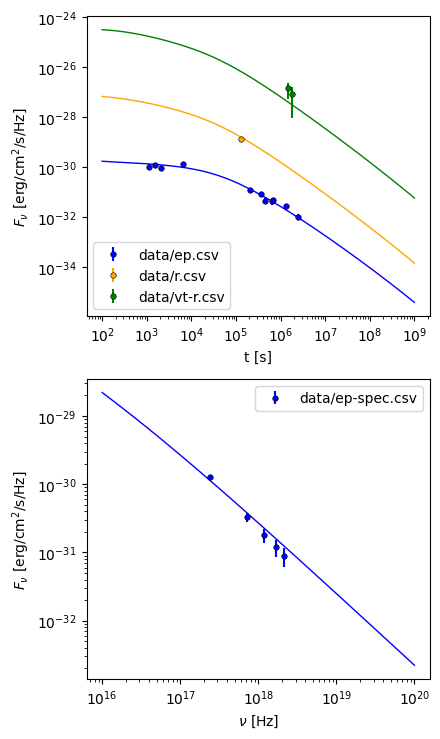

In [12]:
# Function to plot model light curves along with observed data
def draw_bestfit(t,lc_fit, nu, spec_fit):
    fig =plt.figure(figsize=(4.5, 7.5))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    shift = [1,1,200]
    colors = ['blue', 'orange', 'green']
    for i, file, sft, c in zip(range(len(lc_files)), lc_files, shift, colors ):
        df = pd.read_csv(file)
        ax1.errorbar(df["t"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax1.plot(t, np.array(lc_fit[i,:])*sft, color=c,lw=1)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax1.legend()
  
    for i, file, sft, c in zip(range(len(spec_files)), spec_files, shift, colors ):
        df = pd.read_csv(file)
        ax2.errorbar(df["nu"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax2.plot(nu, np.array(spec_fit[:,i])*sft, color=c,lw=1)

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\nu$ [Hz]')
    ax2.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax2.legend()
    plt.tight_layout()

draw_bestfit(t_out, lc, nu_out, spec)

Corner plot saved to: corner_plot.png


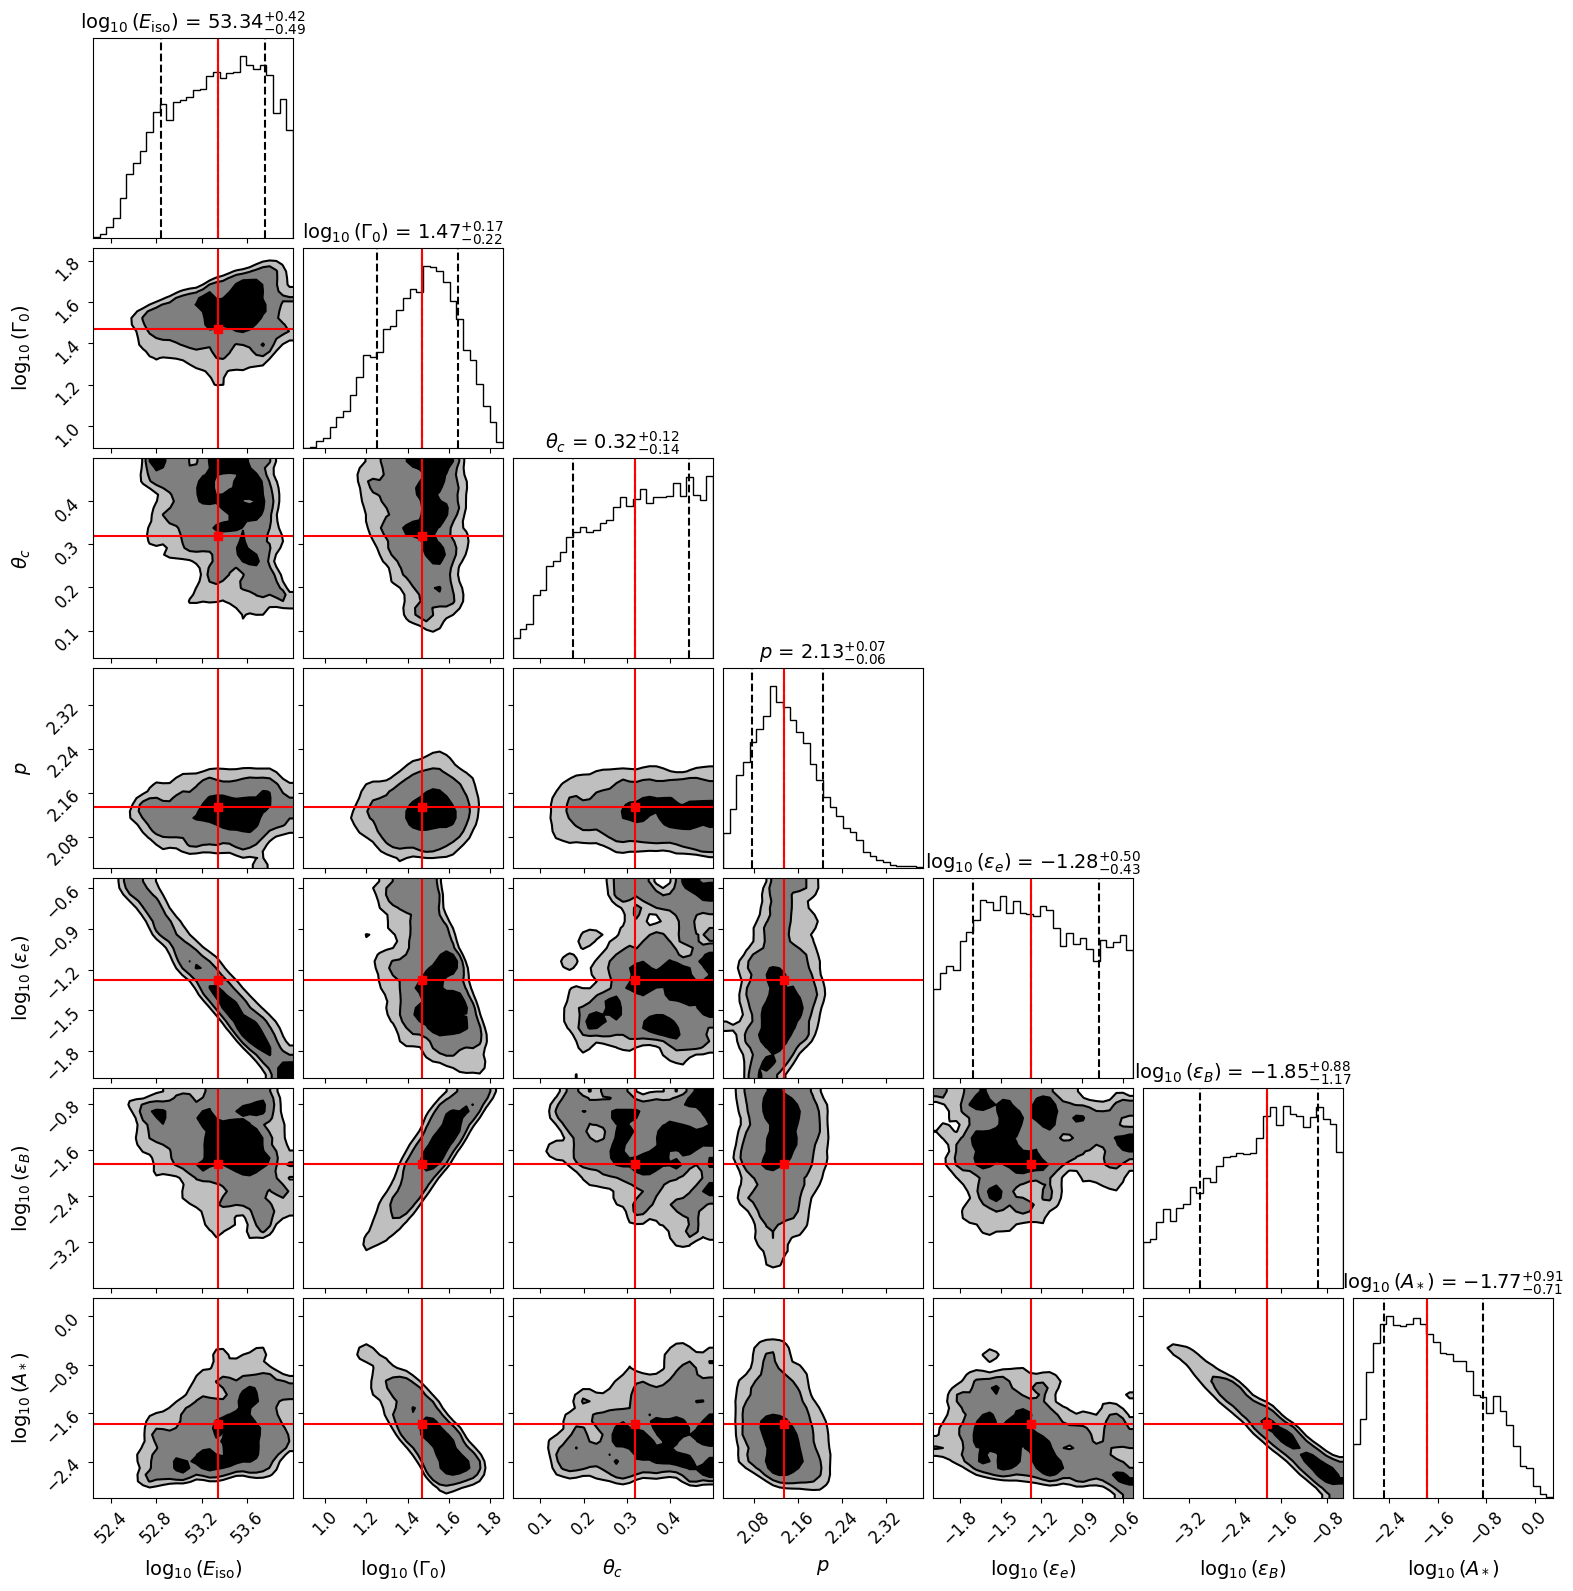

In [13]:
######### 5. VISUALIZATION #########

# Option 1: Use bilby's built-in corner plot (recommended - uses proper LaTeX labels)
# result.bilby_result.plot_corner()

# Option 2: Custom corner plot using the corner package
def plot_corner(flat_chain, labels, filename="corner_plot.png"):
    """Create a corner plot showing parameter correlations and confidence intervals."""
    fig = corner.corner(
        flat_chain,
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],  
        show_titles=True,
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
        truths=np.median(flat_chain, axis=0),  # Show median values
        truth_color='red',
        smooth=1,
        bins=30,
        plot_datapoints=False,
        fill_contours=True,
        levels=[0.16, 0.5, 0.68],  
        color='k',
        alpha=0.5
    )
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12) 
    fig.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Corner plot saved to: {filename}")

# Flatten the samples for corner plot
# Note: For nested sampling, samples are weighted - this is a simplified version
flat_chain = result.samples.reshape(-1, result.samples.shape[-1])

# Create corner plot
plot_corner(flat_chain, result.latex_labels, filename="corner_plot.png")

# For a more accurate weighted corner plot, use bilby's built-in method:
# result.bilby_result.plot_corner(filename="corner_bilby.png")